# LSTM: The basics

In this notebook, we will learn the basics of a Long Short Term Memory (LSTM) using [Pytorch](https://pytorch.org/), an open source machine learning framework based on Python. 

We will build a basic LSTM to predict stock prices in the future. The data is provided in your training environment - but in future you can also access it in [this github repo](https://github.com/mwitiderrick/stockprice).

### Contents

1. [Converting and preparing data](#convert_data)
2. [A multi-variate LSTM](#simple_lstm)

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.style.use('ggplot')

# automatically set device to either cuda (gpu) or cpu
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"device: {device}")


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [3]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop-data'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path + 'sciml-workshop/'
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [4]:
%%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

apt -qq update
apt -qq install s3fs fuse
mkdir -p $2
s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

<a id='convert_data'></a>
## Converting data to sequence structure


One of the critical features of $RNNs$ and $LSTMs$ is that they work on sequences of data. In the lecture notes we saw that the network takes input at a time $t$ and the hiden layer state from $t-1$ and produces an output:

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/lstms-1.png?raw=1" alt="lstms-1" width="500"/>

However we may also want to include measured data from further back in time to help with remembering; so we could want input data from $t-1 \cdots t-n$. We might also have more than one channel of input data, this is called the  **window** of the data. Imagine for example we were predicting stock prices, we could have the history of that stock, but we might also want to know the central bank interest rate, or the strength of one currency relative to another, in this case we have a **multi-variate** problem. So our input data looks more like:

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/lstms-2.png?raw=1" alt="lstms-2" width="500"/>


Also, we might also want to make our $LSTM$ predict more than just one step forward, so we will want to be able to have multiple steps in the output.

We write a function to convert dataframe series into data that is suitable for $LSTM$ training. This function is quite flexible and can be useful in many scenarios, so it is one that you might like to reuse in future if you are training time series models.

As input we pass the data as a `numpy` array. We then also specify how far back in time we wish to look for each prediction `n_in`, so `n_in = 1` means we take just $t$ as input, `n_in=2` means we take $t, t-1$ as input and so on. We specify how far into the future we wish to predict, with the `n_out` variable. `n_out=1` means we predict for $t$, `n_out=2` means we predict for $t, t+1$ and so on. In addition to the window sizes, we can also select the features (columns in the data) to use with the `feature_indices` argument. 

The series data can be infinitely long while the memory of our LSTM cannot not be infinitely large. Therefore, we need to specify the length of the LSTM, or the `timesteps`, which is usually much smaller than the total length of the series. We will set the first dimension of the outputs (`X` and `y` for `Pytorch`) to represent the `batch`; time-dependency is ignored among the batches (i.e., they can be shuffled).

In [4]:
def series_to_pytorch(data, timesteps=10, n_in=1, n_out=1, feature_indices=None):
    """
    Convert a series to pytorch input.
    Arguments:
       data: Sequence of observations as a 2D NumPy array of shape (n_times, n_features)
       n_in: Window size of input X
       n_out: Window size of output y
       feature_indices: select features by indices; pass None to use all features
       timesteps: timesteps of LSTM
    Returns:
       X and y torch Tensors for torch.nn.LSTM
    """
    # sizes
    n_total_times, n_total_features = data.shape[0], data.shape[1]
    n_batches = n_total_times - timesteps - (n_in - 1) - (n_out - 1)
    
    # feature selection
    if feature_indices is None:
        feature_indices = list(range(n_total_features))
    
    # data
    #  (B, T, N_in, F)
    X = np.zeros((n_batches, timesteps, n_in, len(feature_indices)), dtype='float32')
    #  (B, T, N_out, F)
    y = np.zeros((n_batches, n_out, len(feature_indices)), dtype='float32')
    for i_batch in range(n_batches):
        for i_in in range(n_in):
            X_start = i_batch + i_in
            X[i_batch, :, i_in, :] = data[X_start:X_start + timesteps, feature_indices]
        y_start = i_batch + timesteps + n_in - 1
        y[i_batch, :, :] = data[y_start:y_start + n_out, feature_indices]  
    
    # collapse the window and feature dimensions 
    X =  X.reshape(n_batches, timesteps, -1)
    y =  y.reshape(n_batches, -1)
    
    X = torch.Tensor(X)
    y = torch.Tensor(y)
    
    # X = [B,T,F], y = [B,F]
    return X, y

<a id='simple_lstm'></a>

## A multi-variate LSTM

### Importing and treating the data

We first read in our data and inspect it using `pandas`.


In [5]:
# Importing the training set
dataset_train = pd.read_csv(data_path + 'lstm-data/data-train-lstm.csv')

In [6]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [7]:
print(f'Dimensions of raw data: (n_times, n_features) = {dataset_train.shape}')

Dimensions of raw data: (n_times, n_features) = (2035, 8)


In the next cell, we get rid of the `Date` column (the first column) and normalize the rest price columns to `[0, 1]` using `MinMaxScaler` from `scikit-learn`.

In [8]:
# drop `Date` column
values = dataset_train.drop(dataset_train.columns[[0,]], axis=1).values

# normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
print(f'Dimensions of normalized price data: (n_times, n_features) = {scaled.shape}')

pd.DataFrame(scaled).head()

Dimensions of normalized price data: (n_times, n_features) = (2035, 7)


,0,1,2,3,4,5,6
0,0.620235,0.622688,0.621560,0.622576,0.624183,0.103951,0.127882
1,0.622263,0.626144,0.625285,0.623801,0.622141,0.173002,0.212192
2,0.644363,0.639154,0.631078,0.628700,0.626225,0.075513,0.093535
3,0.617194,0.625940,0.629009,0.633803,0.633783,0.079233,0.098117
4,0.618208,0.635902,0.623836,0.624617,0.622345,0.116080,0.142907


### Converting to $LSTM$ structure data


We now want to convert the data to a structure that can be fed to the $LSTM$. To do this we use our `series_to_pytorch` function. In this case, we use 80 as the `timesteps`, looking back 8 steps (`n_in=8`) and projecting forward 4 steps (`n_out=4`) and considering the `Open` and `Close` prices (i.e., `feature_indices=[0, 4]`). 

In [10]:
timesteps = 80
n_in = 8
n_out = 4
feature_indices = [0, 4]

X_train, y_train = series_to_pytorch(scaled, timesteps=timesteps, 
                                        n_in=n_in, n_out=n_out, feature_indices=feature_indices)

# X_train features = n_in * len(feature_indicies) = 8 * 2 = 16; each selected feature (i.e. Open and Close) gets a window of 8 timesteps worth of data
print(f'Dimensions of X_train: (batches, timesteps, features) = {X_train.shape}')
print(f'Dimensions of y_train: (batches, features) = {y_train.shape}')

Dimensions of X_train: (batches, timesteps, features) = torch.Size([1945, 80, 16])
Dimensions of y_train: (batches, features) = torch.Size([1945, 8])


### Building the network
<a id='build_lstm'></a>

The $LSTM$ layers are already coded in `Pytorch` so we do not need to worry about writing the complicated structure. We just need to consider a few hyper-parametes we want to set,

* `hidden_size` - this is the dimensionality of the hidden state and memory cell of the LSTM;
* `num_layers` - Number of LSTM layers. We can stack LSTM layers in this case we will start with 2 stacked LSTMs;
* `dropout` - The amount of dropout to apply on the outputs of each LSTM layer except the last layer;
* `batch_first` - If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Since the series_to_pytorch method returns the batch in the first dimension, we will set `batch_first = True`.

In [13]:
class Net(nn.Module):
    def __init__(self, d_in, d_h, d_out, num_layers=2, dropout=0.4, batch_first=True):
        super().__init__()
        # The first dimension of the input data will represent the batch, so batch_first needs to be set
        self.lstm = nn.LSTM(input_size=d_in, hidden_size=d_h, num_layers=num_layers, dropout=dropout, batch_first=batch_first)
        self.linear = nn.Linear(d_h, d_out)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        # extract only the last time step
        x = x[:, -1, :]
        # project the features into the final output dimension (i.e., final number of output features)
        out = self.linear(x)
        return out

### Create the train loop

Net(
  (lstm): LSTM(16, 32, num_layers=2, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=32, out_features=8, bias=True)
)
Epoch 0: train mse 0.0403
Epoch 1: train mse 0.0152
Epoch 2: train mse 0.0043
Epoch 3: train mse 0.0030
Epoch 4: train mse 0.0025
Epoch 5: train mse 0.0020
Epoch 6: train mse 0.0019
Epoch 7: train mse 0.0018
Epoch 8: train mse 0.0017
Epoch 9: train mse 0.0016
Epoch 10: train mse 0.0016
Epoch 11: train mse 0.0015
Epoch 12: train mse 0.0015
Epoch 13: train mse 0.0013
Epoch 14: train mse 0.0014
Epoch 15: train mse 0.0013
Epoch 16: train mse 0.0013
Epoch 17: train mse 0.0013
Epoch 18: train mse 0.0015
Epoch 19: train mse 0.0012
Epoch 20: train mse 0.0011
Epoch 21: train mse 0.0011
Epoch 22: train mse 0.0011
Epoch 23: train mse 0.0011
Epoch 24: train mse 0.0010
Epoch 25: train mse 0.0011
Epoch 26: train mse 0.0011
Epoch 27: train mse 0.0011
Epoch 28: train mse 0.0010
Epoch 29: train mse 0.0011
Training finished!


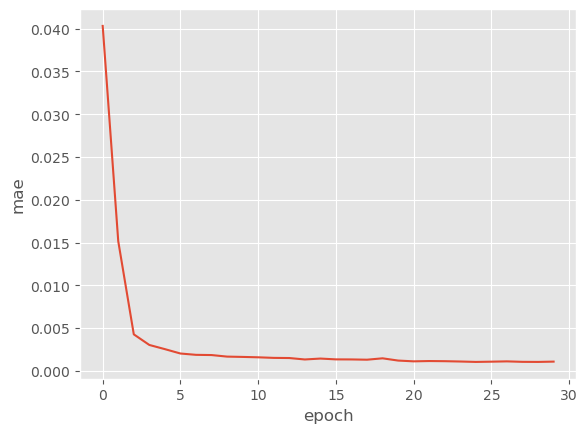

In [14]:
# Define training parameters
input_size = 16
hidden_size = 32
output_size = 8
learning_rate = 1e-3
num_epochs = 30
batch_size = 128

# Create LSTM model
model = Net(input_size, hidden_size, output_size).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a DataLoader to give you data in batches
loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

# Define list to collect losses for later visualisation
epoch_losses = [] 

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    ep_loss = []
    avg_ep_loss = 0. 
        
    for data, target in loader:
        # data = (batch, timesteps=80, input features=16)
        # target = (batch, output features=8)
        data, target = data.to(device), target.to(device)
        # y_pred = (batch, output feature=8)
        test_y_pred = model(data)
        loss = criterion(test_y_pred, target)
        ep_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_ep_loss = sum(ep_loss)/len(ep_loss)
    epoch_losses.append(avg_ep_loss)
    print("Epoch %d: train mse %.4f" % (epoch, avg_ep_loss))

print('Training finished!')

plt.figure(dpi=100)
plt.plot(epoch_losses)
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

### Making predictions with our model

We now use model that we just built to predict on previously un-seen data. We read in `data-test.csv` and get the stock prices from that data.


In [11]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv(data_path + 'lstm-data/data-test-lstm.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
print("Test dataset shape: ", dataset_test.shape)

Test dataset shape:  (16, 8)


In [16]:
dataset_test.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-24,220.10,221.25,217.05,219.55,219.80,2171956,4771.34
1,2018-10-23,221.10,222.20,214.75,219.55,218.30,1416279,3092.15
2,2018-10-22,229.45,231.60,222.00,223.05,223.25,3529711,8028.37
3,2018-10-19,230.30,232.70,225.50,227.75,227.20,1527904,3490.78
4,2018-10-17,237.70,240.80,229.45,231.30,231.10,2945914,6961.65


The testing data contain 16 time steps. We will concatenate them to the training data for time extension. 

In [17]:
# Getting the predicted stock price of 2017
dataset_extended = pd.concat((dataset_train, dataset_test), axis=0)
values_extended = dataset_extended.drop(dataset_extended.columns[[0,]], axis=1).values
scaled_extended = scaler.transform(values_extended)
print(f'Dimensions of normalized price data: (n_times, n_features) = {scaled_extended.shape}')

Dimensions of normalized price data: (n_times, n_features) = (2051, 7)


In [18]:
def test(model, dataset, timesteps, n_in, n_out, feature_indices):
    # using the last points to generate testing data
    X_test, y_test = series_to_pytorch(scaled_extended[-(timesteps + n_in + n_out - 2 + len(dataset)):], 
                                        timesteps=timesteps, n_in=n_in, n_out=n_out, feature_indices=feature_indices)
    ds_len = X_test.shape[0]
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=ds_len)

    # get single batch of data - since we set the batch_size to the length of the dataset, we will retrieve the full dataset
    test_data, test_target = next(iter(test_loader))
    test_data, test_target = test_data.to(device), test_target.to(device)
    model.eval()
    y_pred = model(test_data)
    
    print(f"MSE Loss {criterion(y_pred, test_target)}")

    print(f'Dimensions of X_test: (batches, timesteps, features) = {test_data.shape}')
    print(f'Dimensions of y_test (target): (batches, features) = {test_target.shape}')
    print(f'Dimensions of y_pred (prediction): (batches, features) = {y_pred.shape}')
    
    return test_data, test_target, y_pred

test_data, test_target, test_y_pred = test(model, dataset_test, timesteps, n_in, n_out, feature_indices)

MSE Loss 0.06659533083438873
Dimensions of X_test: (batches, timesteps, features) = torch.Size([16, 80, 16])
Dimensions of y_test: (batches, features) = torch.Size([16, 80, 16])
Dimensions of y_pred: (batches, features) = torch.Size([16, 8])


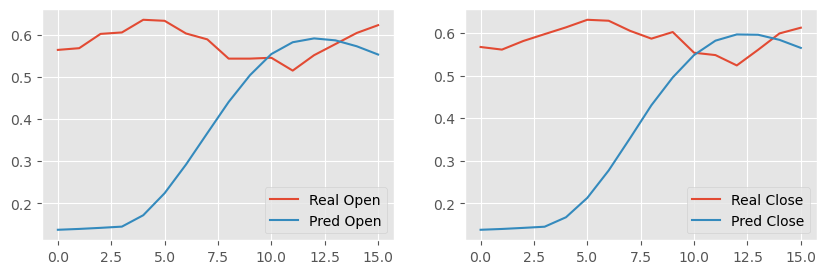

In [19]:
def plot_pred_vs_target(pred, target, feature_indices, n_out):
    # Visualising the results
    fig, ax = plt.subplots(1, len(feature_indices), dpi=100, 
                        figsize=(5 * len(feature_indices), 3), squeeze=False)
    for i, index in enumerate(feature_indices):
        # we are ploting the last point from the output window
        ax[0, i].plot(target[:, i + (n_out - 1) * len(feature_indices)], 
                    label = 'Real ' + dataset_train.keys()[index + 1])
        ax[0, i].plot(pred[:, i + (n_out - 1) * len(feature_indices)], 
                    label = 'Pred ' + dataset_train.keys()[index + 1])
        ax[0, i].legend()
    plt.show()
    

pred = test_y_pred.cpu().detach().numpy()
target = test_target.cpu().detach().numpy()
plot_pred_vs_target(pred, target, feature_indices, n_out)

### Exercise

1) Build a network with three or four $LSTM$ layers. How does this affect the performance?
2) Change the LSTM timesteps (`timesteps`) - how does a longer/shorter one affect the predictions?
3) Try other window sizes and features.
